In [36]:
import numpy as np
import scipy as sp
import matplotlib.pyplot as plt
from abc import ABC, abstractmethod

In [37]:
def d1(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r -q + sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def d2(St, K, T, t, r, q, sigma):
    return (np.log(St/K) + (r - q - sigma**2/2)*(T-t))/(sigma*np.sqrt(T - t))

def BSMcall(St, K, T, t, r, q, sigma):
    """
    St: Stock price at time t
    t: reference time
    T: time to maturity
    r: risk free rate
    q : dividend rate
    sigma: volatility
    """
    _d1 = sp.special.ndtr(d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

    return St*np.exp(-q*(T-t))*_d1 - K*np.exp(-r*(T-t))*_d2


def BSMdigitalCall(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(d2(St, K, T, t, r, q, sigma))

def BSMput(St, K, T, t, r, q, sigma):
    _d1 = sp.special.ndtr(-d1(St, K, T, t, r, q, sigma))
    _d2 = sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))

    return K*np.exp(-r*(T-t))*_d2 - St*np.exp(-q*(T-t))*_d1

def BSMdigitalPut(St, K, T, t, r, q, sigma):
    return np.exp(-r*(T-t))*sp.special.ndtr(-d2(St, K, T, t, r, q, sigma))


In [64]:
class StockMovementGenerator(ABC):
    """Abstract base class for generating stock price movements"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int, T:float):
        self.initial_price = initial_price
        self.n = n_steps # Dimensionality of Monte Carlo / Number of Increments
        self.d = n_paths # Number of Iterations / Paths
        self.T = T  # Timespan
        self.dt = self.T/(self.n-1)

    @abstractmethod
    def generate(self):
        """Generate price movements"""
        pass

class GeometricBrownianMotion(StockMovementGenerator):
    """Generate stock prices using Geometric Brownian Motion"""

    def __init__(self, initial_price: float, n_steps: int, n_paths : int,
                 r: float, q:float, sigmaArray: np.array , T: float):
        super().__init__(initial_price, n_steps, n_paths, T)
        self.S0 = initial_price # Initial stock price
        self.r = r  # Risk-free interest rate
        self.q = q # Dividend rate
        self.sigmaArray = sigmaArray  # historic volatility
        self.times = np.linspace(0., self.T, self.n)
        self.timesArray = np.array([self.times for i in range(self.d)]).transpose()

    def generate(self):
        """
        Generate prices using GBM
        The generator function can take in a changing volatility

        """

         # Computing root-mean-square sigma
        _rmsSigma = np.ones(shape=self.sigmaArray.shape)
        _rmsSigma[0] = self.sigmaArray[0]
        _rmsSigma[1:] = np.sqrt((self.sigmaArray[:-1]**2 + self.sigmaArray[1:]**2)/2)
        _rmsSigma = np.repeat(_rmsSigma.reshape(self.n,1), self.d, axis = 1)

        # Bt2 - Bt1 ~ Normal with mean 0 and variance t2-t1
        dB = np.zeros((self.n, self.d))
        dB[1:, :] = np.sqrt(self.dt) * np.random.normal(size=(self.n-1, self.d))
        # Simulation of Arithmetic brownian motion
        B = np.cumsum(dB, axis=0)
        S = self.S0*np.exp((self.r-self.q-_rmsSigma**2/2)*self.timesArray + _rmsSigma*B)
        return S



In [39]:
class BinomialTree:
    def __init__(self, S0, T, r, q, sigma, noSteps):
        self.r = r
        self.q = q
        self.T = T
        self.noSteps = noSteps
        self.dt = T/(noSteps - 1)
        self.drift = (r-q-sigma**2/2)*self.dt
        self.randomInc = sigma*np.sqrt(self.dt)
        self.layers = [np.zeros(i+1) for i in range(noSteps)]
        self.layers[0][0] = S0

        self.split()

    name = 'Binomial Tree'

    def split(self):

        for i in range(1, self.noSteps):

            for j in range(i+1):

                self.layers[i][j] = self.layers[i-1][0]*np.exp(-self.randomInc + 2*j*self.randomInc)

            self.layers[i][:]*= np.exp(self.drift)

    def evaluateOption(self, optionPayoff, filterFn = None ):

        prevLayer = optionPayoff(self.layers[-1])
        currLayer = np.zeros(prevLayer.size - 1)

        while currLayer.size > 0:

            for j in range(currLayer.size):

                if filterFn is not None:
                    prevLayer*= filterFn(self.layers[prevLayer.size-1])

                currLayer[j] = np.exp(-self.r*self.dt)*(prevLayer[j] + prevLayer[j+1])/2

            prevLayer = currLayer
            currLayer = np.zeros(prevLayer.size - 1)

        return prevLayer[0]


In [41]:
def priceBarrierOption(n_steps, timeArray, expiryPayoff, replicationOption, S0, K, T, r, q , sigmaArray, B):

    alpha = np.zeros(n_steps)
    RMSSigma = np.sqrt(np.mean(sigmaArray**2))

    # Find the value of the portfolio at B at any intermediary times
    # Buy alpha amount of replication Options with strike on the barrier to cancel portoflio value
    for tIdx in np.flip(np.arange(n_steps-1)):

        _t = timeArray[tIdx]

        forwardSigma = np.sqrt(np.mean(sigmaArray[tIdx:]**2))
        basePortfolio = expiryPayoff(St = B, K = K, T= T, t= _t, r = r, q= q, sigma = forwardSigma, B = B)

        # Create a list of arguments for all extra replication options purchased on the barrier
        barrierArgs = []
        for j in np.flip(np.arange(tIdx, n_steps-1)):

            _T = timeArray[j+1]
            _Args = (B, B, _T, _t, r, q, np.sqrt(np.mean(sigmaArray[tIdx:j+1]**2)))
            barrierArgs.append(_Args)

        # Take the value of the current tIdx replication option on the barrier
        barrierOptionVal = replicationOption(*_Args)

        # Adjust the portfolio
        portfolio = basePortfolio

        for idx,_args in enumerate(barrierArgs):

            portfolio -= alpha[-(idx+1)]*replicationOption(*_args)

        alpha[tIdx] = portfolio/barrierOptionVal

    # Evaluate rms Forward Sigma
    rmsSigma = np.zeros(n_steps)
    for i in range(n_steps):
        rmsSigma[i] = np.sqrt(np.mean(sigmaArray[i:]**2))

    # Evaluate price of Barrier OPTION at t = 0
    difference = np.sum(alpha[:-1]*replicationOption(St = S0, K = B, T = timeArray[1:], t = 0, r = r, q = q, sigma = rmsSigma[:-1]))

    baseVal = expiryPayoff(St = S0, K = K, T = T, t = 0, r = r, q = q, sigma = rmsSigma[0], B = B)

    return baseVal - difference


# CONVERGENCE

## Simulating the UP AND OUT CALL with B = 120

The replication of an UP AND OUT CALL - $UPOUTCALL(K)$ - is made via buying a vanilla call for the same strike - $C1(K)$, then selling a call with the strike at the barrier, that is -> $C2(B)$ and $(B-K)$ notional of digital call with strike at the barrier, that is -> $(B-K) \cdot DigitalCall(B)$.

The replication portfolio is completed when the value of the portfolio is $0$ on the Barrier, e.g. at $ P(B, t_n) = 0$ for any $t_n$ smaller than maturity $T$.

To cancel the value of the portfolio on the barrier we sell additional calls with strike on the barrier $C_n(B, T=t_n)$ with expiries at all intermediary points and with notional based on the value of the portfolio at that point.

In [42]:
def upOutCallExpiryPayoff(St, K, T, t, r, q, sigma, B):

    _call1 = BSMcall(St = St, K = K, T = T, t = t, r = r, q = q, sigma = sigma)

    _call2 = BSMcall(St = St, K = B, T = T, t = t, r = r, q = q, sigma = sigma)

    _digitalCall = BSMdigitalCall(St = St, K = B, T = T, t = t, r = r, q = q, sigma = sigma)

    return _call1 - (_call2 + (B-K)*_digitalCall)

In [43]:
t = 0
T = 1
K = 100
S0 = 100
q = 0
sigma = .1
r = .05
B = 105
K = 100
epsilon = 1e-6

In [44]:
sT = BinomialTree(S0, T, r, q, sigma, noSteps = np.power(2,11))

In [45]:
upOutCallRef = sT.evaluateOption(optionPayoff = lambda x : (x < B)*np.maximum(x - K,0), filterFn = lambda x : x < B)

Using parameters: r = 0.05, q = 0.00, sigma = 0.10, t = 0.00 years, T = 1.00 years, S0 = 100.00, K = 100.00, B : 105.00


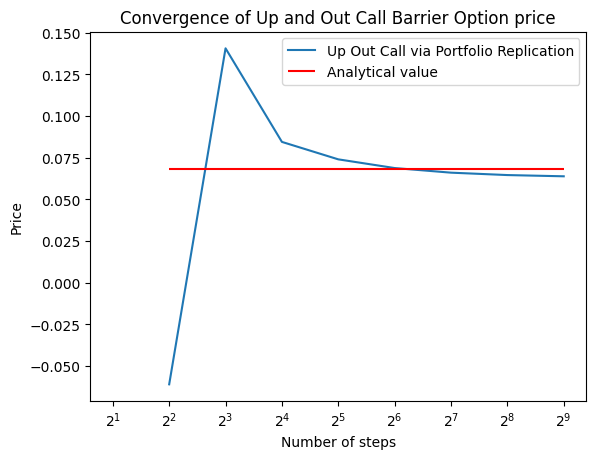

In [15]:
minPower = 2
maxPower = 10
stepsArray = np.power(2,np.arange(minPower, maxPower))

# Down Out Call Price array
dOCpriceArray = np.zeros(len(stepsArray))

print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, B : {B :.2f}')
for idx, stepsNo in enumerate(stepsArray):
    timeArray= np.linspace(0,T,stepsNo)
    sigmaArray = sigma*np.ones(stepsNo)
    dOCpriceArray[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = r, q = q, sigmaArray = sigmaArray, B = B)

fig,ax = plt.subplots()
ax.set_xscale("log", base = 2)
ax.plot(stepsArray, dOCpriceArray, label = 'Up Out Call via Portfolio Replication')
ax.hlines(y = upOutCallRef, xmin = stepsArray[0], xmax = stepsArray[-1], color = 'red', label = 'Analytical value')
ax.set_title(f'Convergence of Up and Out Call Barrier Option price')
ax.set_xlabel('Number of steps')
ax.set_ylabel('Price')
ax.legend()

There is a slight mismatch as the binary Tree algorithm was used with only $2^{11}$ time steps, giving it a noticeable bias

Otherwise, the estimates converge to the same value

## Simulating the DOWN AND OUT CALL with B = 95

In [16]:
B = 95

In [17]:
def downOutCallExpiryPayoff(St, K, T, t, r, q, sigma, B):
    return BSMcall(St = St, K = K, T = T, t = t, r = r, q = q, sigma = sigma)

In [ ]:
# Reference value obtained using external analytical calculator
downOutCallRef = sT.evaluateOption(optionPayoff = lambda x : (x > B)*np.maximum(x - K,0), filterFn = lambda x : x > B)

Using parameters: r = 0.05, q = 0.00, sigma = 0.10, t = 0.00 years, T = 1.00 years, S0 = 100.00, K = 100.00, B : 95.00


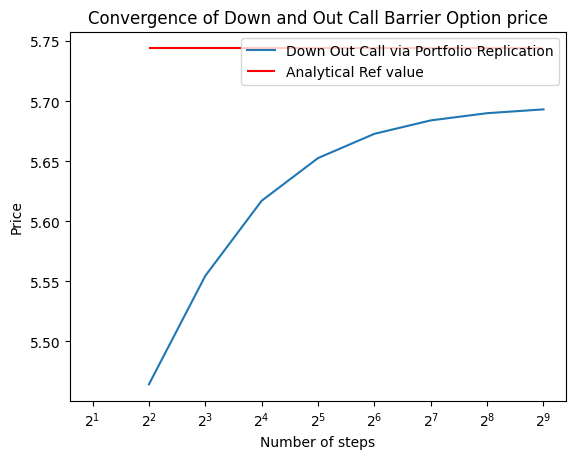

In [19]:
minPower = 2
maxPower = 10

stepsArray = np.power(2,np.arange(minPower, maxPower))
priceArray = np.zeros(len(stepsArray))

print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, B : {B :.2f}')
for idx, stepsNo in enumerate(stepsArray):
    timeArray= np.linspace(0,T,stepsNo)
    sigmaArray = sigma*np.ones(stepsNo)
    priceArray[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = downOutCallExpiryPayoff, replicationOption = BSMput, S0 = S0, K = K, T = T, r = r, q = q, sigmaArray = sigmaArray, B = B)

fig,ax = plt.subplots()
ax.set_xscale("log", base = 2)
ax.plot(stepsArray, priceArray, label = 'Down Out Call via Portfolio Replication')
ax.hlines(y = downOutCallRef, xmin = stepsArray[0], xmax = stepsArray[-1], color = 'red', label = 'Analytical Ref value')
ax.set_title(f'Convergence of Down and Out Call Barrier Option price')
ax.set_xlabel('Number of steps')
ax.set_ylabel('Price')
ax.legend()

## Varying the final Payoff of the Up and Out call and observe Convergence Impact

i) Make the final payoff constant above the barrier

To do this we add a $\beta \cdot H(S-B)$ term to the final payoff. In other words we add $\beta$ digital call with strike on barrier

In [ ]:
B = 120
beta = 5

In [ ]:
def upOutCallExpiryPayoff1(St, K, T, t, r, q, sigma, B):

    _call1 = BSMcall(St = St, K = K, T = T, t = t, r = r, q = q, sigma = sigma)

    _call2 = BSMcall(St = St, K = B, T = T, t = t, r = r, q = q, sigma = sigma)

    _digitalCall = BSMdigitalCall(St = St, K = B, T = T, t = t, r = r, q = q, sigma = sigma)

    return _call1 - (_call2 + (B-K)*_digitalCall) + beta*_digitalCall

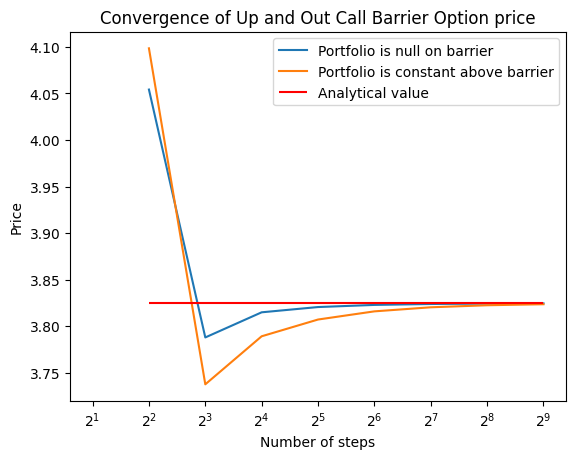

In [ ]:
priceArray1 = np.zeros(len(stepsArray))
for idx, stepsNo in enumerate(stepsArray):
    timeArray= np.linspace(0,T,stepsNo)
    sigmaArray = sigma*np.ones(stepsNo)
    priceArray1[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff1, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = r, q = q, sigmaArray = sigmaArray, B = B)

fig,ax = plt.subplots()
ax.set_xscale("log", base = 2)
ax.plot(stepsArray, dOCpriceArray, label = 'Portfolio is null on barrier ')
ax.plot(stepsArray, priceArray1, label = 'Portfolio is constant above barrier')
ax.hlines(y = upOutCallRef, xmin = stepsArray[0], xmax = stepsArray[-1], color = 'red', label = 'Analytical value')
ax.set_title(f'Convergence of Up and Out Call Barrier Option price')
ax.set_xlabel('Number of steps')
ax.set_ylabel('Price')
ax.legend()

## Vary time step size density

Make time steps more frequent towards the end of term

Using parameters: r = 0.05, q = 0.00, sigma = 0.10, t = 0.00 years, T = 1.00 years, S0 = 100.00, K = 100.00, B : 120.00


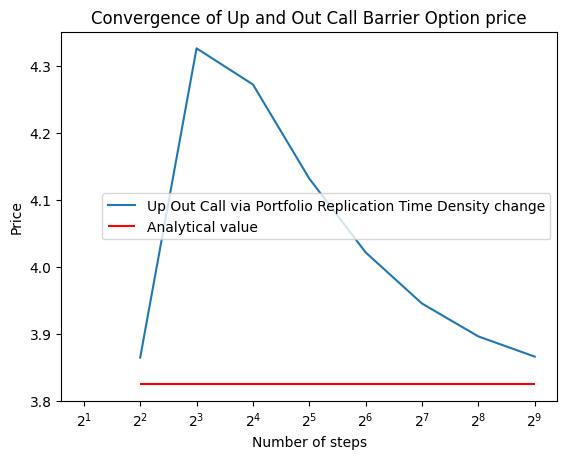

In [ ]:
minPower = 2
maxPower = 10
stepsArray = np.power(2,np.arange(minPower, maxPower))
# Down Out Call Price array
priceArray = np.zeros(len(stepsArray))

print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, B : {B :.2f}')
for idx, stepsNo in enumerate(stepsArray):
    timeArray = np.sin(np.linspace(0, 1, stepsNo)*np.pi/2)*T
    sigmaArray = sigma*np.ones(stepsNo)
    priceArray[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = r, q = q, sigmaArray = sigmaArray, B = B)

fig,ax = plt.subplots()
ax.set_xscale("log", base = 2)
ax.plot(stepsArray, priceArray, label = 'Up Out Call via Portfolio Replication Time Density change')
ax.hlines(y = upOutCallRef, xmin = stepsArray[0], xmax = stepsArray[-1], color = 'red', label = 'Analytical value')
ax.set_title(f'Convergence of Up and Out Call Barrier Option price')
ax.set_xlabel('Number of steps')
ax.set_ylabel('Price')
ax.legend()

Changing the time density changed the bias from a negative one to a positive one

# Time dependent volatility

Use 3 different volatility behaviours

i) increasing

ii) decreasing

iii) bump in the middle

Choose volatility functions such that the Root Mean Square of volatility is identical

In [46]:
n_steps = 500
sigma0 = .05
bump_size = .2
decayExp =  lambda _steps : sigma0 + .05*np.exp(-10*np.linspace(0,T,_steps))
sigmaArrayDeExp = decayExp(n_steps)
sigmaArrayInExp = np.flip(sigmaArrayDeExp)

def sigmaArrayBump(n_steps, sigma0, bump_size):
    sigmaArrayDeExp = decayExp(n_steps)
    sigmaArrayInExp = np.flip(sigmaArrayDeExp)
    rmsSigma = np.sqrt(np.mean(sigmaArrayDeExp**2))
    bumpStepsLength = int(bump_size*n_steps)
    _sigmaArrayBump = np.ones(n_steps)*sigma0
    bottomIdx = int(n_steps/2 - bumpStepsLength/2)
    topIdx = int(n_steps/2 + bumpStepsLength/2)
    _sigmaArrayBump[bottomIdx:topIdx] = np.sqrt((rmsSigma**2 - (1-bump_size)*sigma0**2)/bump_size)
    return _sigmaArrayBump

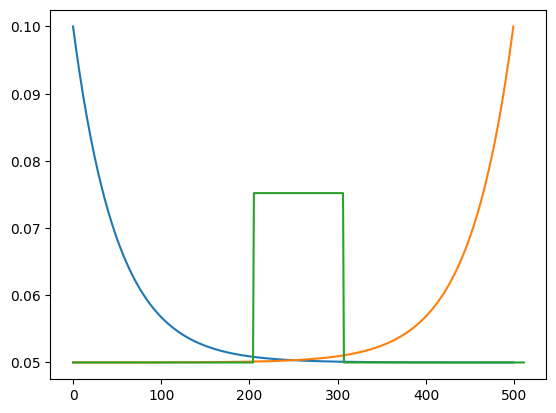

In [47]:
plt.plot(sigmaArrayDeExp)
plt.plot(sigmaArrayInExp)
plt.plot(sigmaArrayBump(stepsNo, sigma0, bump_size))

## i) Rapidly decreasing volatility function

Using parameters: r = 0.05, q = 0.00, sigma = 0.10, t = 0.00 years, T = 1.00 years, S0 = 100.00, K = 100.00, B : 105.00


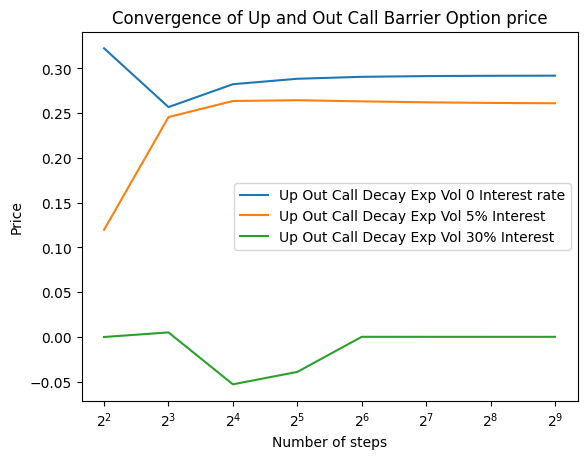

In [91]:
B = 105
minPower = 2
maxPower = 10
stepsArray = np.power(2,np.arange(minPower, maxPower))

# Down Out Call Price array
priceArray1 = np.zeros(len(stepsArray))
priceArray2 = np.zeros(len(stepsArray))
priceArray3 = np.zeros(len(stepsArray))

print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, B : {B :.2f}')
for idx, stepsNo in enumerate(stepsArray):
    timeArray= np.linspace(0,T,stepsNo)
    sigmaArray = decayExp(stepsNo)
    priceArray1[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = 0, q = q, sigmaArray = sigmaArray, B = B)
    priceArray2[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = 0.05, q = q, sigmaArray = sigmaArray, B = B)
    priceArray3[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = 0.3, q = q, sigmaArray = sigmaArray, B = B)

fig,ax = plt.subplots()
ax.set_xscale("log", base = 2)
ax.plot(stepsArray, priceArray1, label = 'Up Out Call Decay Exp Vol 0 Interest rate')
ax.plot(stepsArray, priceArray2, label = 'Up Out Call Decay Exp Vol 5% Interest')
ax.plot(stepsArray, priceArray3, label = 'Up Out Call Decay Exp Vol 30% Interest')
ax.set_title(f'Convergence of Up and Out Call Barrier Option price')
ax.set_xlabel('Number of steps')
ax.set_ylabel('Price')
ax.legend()

The interest clearly affects how likely it is for the underlying to hit the Barrier

Given it is an up & out call, a higher interest nullifies more paths, bringing the value of the barrier call down to 0

## ii) rapidly decreasing volatility function

Using parameters: r = 0.05, q = 0.00, sigma = 0.10, t = 0.00 years, T = 1.00 years, S0 = 100.00, K = 100.00, B : 105.00


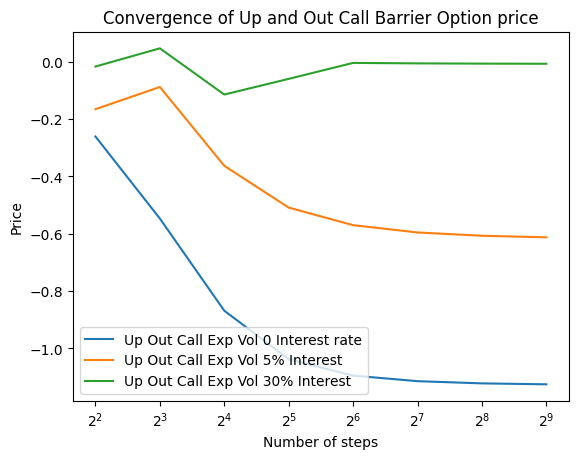

In [92]:
B = 105
minPower = 2
maxPower = 10
stepsArray = np.power(2,np.arange(minPower, maxPower))

# Down Out Call Price array
priceArray1 = np.zeros(len(stepsArray))
priceArray2 = np.zeros(len(stepsArray))
priceArray3 = np.zeros(len(stepsArray))

print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, B : {B :.2f}')
for idx, stepsNo in enumerate(stepsArray):
    timeArray= np.linspace(0,T,stepsNo)
    sigmaArray = np.flip(decayExp(stepsNo))
    priceArray1[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = 0, q = q, sigmaArray = sigmaArray, B = B)
    priceArray2[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = 0.05, q = q, sigmaArray = sigmaArray, B = B)
    priceArray3[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = 0.3, q = q, sigmaArray = sigmaArray, B = B)

fig,ax = plt.subplots()
ax.set_xscale("log", base = 2)
ax.plot(stepsArray, priceArray1, label = 'Up Out Call Exp Vol 0 Interest rate')
ax.plot(stepsArray, priceArray2, label = 'Up Out Call Exp Vol 5% Interest')
ax.plot(stepsArray, priceArray3, label = 'Up Out Call Exp Vol 30% Interest')
ax.set_title(f'Convergence of Up and Out Call Barrier Option price')
ax.set_xlabel('Number of steps')
ax.set_ylabel('Price')
ax.legend()

The value of the Barrier Option is negative for an increasing exponential volatility.

The way we replicate the value of the Up and Out Barrier Option is by buying calls to cancel the value of the Option on the barrier.

The number of calls bought at each preceeding time step to maturity is based on the ratio of the Portfolio to the value of the call. The larger the forward volatility the larger the amount of calls needed to cancel the Portfolio on the Barrier.

Hence, because it is an increasing exponential, the forward volatility will be always large, and given this is a back stepping algorithm, all call amounts will be large in turn.

This makes the algorithm not well suited for Barrier Option Replication when the volatilties is varying wildly

Thus, an alternative algorithm is needed to infer the value of barrier options under varying volatility, such as Monte Carlo.

The portfolio replication algorigthm is numerically unstable in this regime.

## iii) Volatility with a bump in the center

Using parameters: r = 0.05, q = 0.00, sigma = 0.10, t = 0.00 years, T = 1.00 years, S0 = 100.00, K = 100.00, B : 105.00


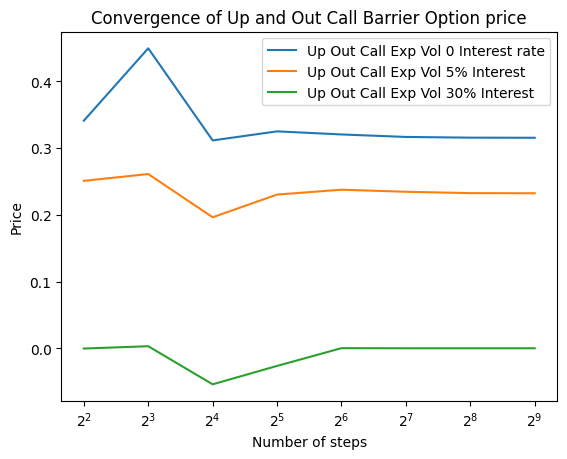

In [94]:
B = 105
minPower = 2
maxPower = 10
stepsArray = np.power(2,np.arange(minPower, maxPower))

# Down Out Call Price array
priceArray1 = np.zeros(len(stepsArray))
priceArray2 = np.zeros(len(stepsArray))
priceArray3 = np.zeros(len(stepsArray))

print(f'Using parameters: r = {r:.2f}, q = {q:.2f}, sigma = {sigma:.2f}, t = {t:.2f} years, T = {T:.2f} years, S0 = {S0:.2f}, K = {K:.2f}, B : {B :.2f}')
for idx, stepsNo in enumerate(stepsArray):
    timeArray= np.linspace(0,T,stepsNo)
    sigmaArray = sigmaArrayBump(stepsNo, sigma0, bump_size)
    priceArray1[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = 0, q = q, sigmaArray = sigmaArray, B = B)
    priceArray2[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = 0.05, q = q, sigmaArray = sigmaArray, B = B)
    priceArray3[idx] = priceBarrierOption(n_steps = stepsNo, timeArray=timeArray, expiryPayoff = upOutCallExpiryPayoff, replicationOption = BSMcall, S0 = S0, K = K, T = T, r = 0.3, q = q, sigmaArray = sigmaArray, B = B)

fig,ax = plt.subplots()
ax.set_xscale("log", base = 2)
ax.plot(stepsArray, priceArray1, label = 'Up Out Call Exp Vol 0 Interest rate')
ax.plot(stepsArray, priceArray2, label = 'Up Out Call Exp Vol 5% Interest')
ax.plot(stepsArray, priceArray3, label = 'Up Out Call Exp Vol 30% Interest')
ax.set_title(f'Convergence of Up and Out Call Barrier Option price')
ax.set_xlabel('Number of steps')
ax.set_ylabel('Price')
ax.legend()